# Test GroundingDINO

In [1]:
import os
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm
from torchvision.ops import box_convert
import torch
from ssfm.files import read_camera_parameters_webodm, read_camera_parameters_agisoft
from joblib import Parallel, delayed

import groundingdino.datasets.transforms as T
from groundingdino.util.inference import load_model, predict, annotate

import matplotlib.pyplot as plt

/home/zchen256/miniconda3/envs/grounding_dino/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
class GroundingDINOMaskFilter(object):
    def __init__(self):
        pass

    def load_image(self, image_path):
        transform = T.Compose(
            [
                T.RandomResize([800], max_size=1333),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
        image_source = Image.open(image_path).convert("RGB")
        image = np.asarray(image_source)
        image_source = Image.fromarray(image)
        image_transformed, _ = transform(image_source, None)
        return image, image_transformed

    def predict_bounding_boxes(self, image_path, grounding_dino_config):
        weights_path = grounding_dino_config['weights_path']
        config_path = grounding_dino_config['config_path']
        text_prompts = grounding_dino_config['text_prompt']
        box_treshold = grounding_dino_config['box_treshold']
        text_treshold = grounding_dino_config['text_treshold']
        device = grounding_dino_config['device']
        remove_background = grounding_dino_config['remove_background']


        # load the model
        assert os.path.exists(weights_path), "The weights file does not exist: {}".format(weights_path)
        assert os.path.exists(config_path), "The config file does not exist: {}".format(config_path)
        model = load_model(config_path, weights_path, device)

        image_source, image = self.load_image(image_path)

        # get image width and height
        self.width, self.height, _ = image_source.shape

        boxes_all = []
        logits_all = []
        phrases_all = []
        class_ids_all = []
        for label_id, text_prompt in enumerate(text_prompts):
            # predict the bounding boxes
            # boxes: [N, 4] where N is the number of boxes
            # logits: [N] scores of the boxes
            # phrases: [N] the predicted phrases of the boxes
            boxes, logits, phrases = predict(model=model, 
                                                image=image, 
                                                caption=text_prompt, 
                                                box_threshold=box_treshold, 
                                                text_threshold=text_treshold)
            

            if remove_background:
                boxes_width = boxes[:, 2]
                boxes_height = boxes[:, 3]
                boxes_area = boxes_width * boxes_height
                boxes = boxes[boxes_area < 0.9]
                logits = logits[boxes_area < 0.9]
                phrases = [phrases[i] for i in range(len(phrases)) if boxes_area[i] < 0.9]


            boxes_all.append(boxes)
            logits_all.append(logits)
            phrases_all = phrases_all + phrases
            class_ids_all += [label_id] * len(boxes)

        # merge the boxes from different text prompts
        boxes = torch.cat(boxes_all, dim=0)
        logits = torch.cat(logits_all, dim=0)
        phrases = phrases_all

        annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

         # boxes have the format of [cx, cy, w, h] and need to be converted to [x1, y1, x2, y2]
        boxes = boxes * torch.Tensor([self.width, self.height, self.width, self.height])
        boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
        # concatenate the boxes and logits
        logits = logits.reshape(-1, 1)
        class_ids = np.asarray(class_ids_all).reshape(-1, 1)
        prediction = np.concatenate((boxes, logits, class_ids), axis=1)
        return annotated_frame


In [68]:
grounding_dino_config = {}
grounding_dino_config['weights_path'] = "../grounding_DINO/groundingdino_swint_ogc.pth"
grounding_dino_config['config_path'] = "../grounding_DINO/GroundingDINO_SwinT_OGC.py"
grounding_dino_config['prediction_save_folder_path'] = "../../data/courtright/grounding_dino_predictions"
grounding_dino_config['text_prompt'] = ['cabinet', 'microwave']
grounding_dino_config['box_treshold'] = 0.15
grounding_dino_config['text_treshold'] = 0.25
grounding_dino_config['device'] = 'cuda:5'
grounding_dino_config['remove_background'] = True

image_path = "../../data/scannet/ssfm_train/scene0003_01/photos/86.jpg"

mask_filter = GroundingDINOMaskFilter()

prediction_image = mask_filter.predict_bounding_boxes(image_path, grounding_dino_config)

final text_encoder_type: bert-base-uncased


/home/zchen256/miniconda3/envs/grounding_dino/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/zchen256/miniconda3/envs/grounding_dino/lib/python3.8/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/zchen256/miniconda3/envs/grounding_dino/lib/python3.8/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between th

[[6.60281830e+01 3.24935913e-01 5.56062561e+02 2.75017761e+02
  5.88461101e-01 0.00000000e+00]
 [5.52048645e+02 7.65533447e-02 9.67159729e+02 2.33172577e+02
  4.77200210e-01 0.00000000e+00]
 [5.33633972e+02 1.98909851e+02 9.67243713e+02 9.71765808e+02
  4.65610266e-01 0.00000000e+00]
 [5.34353577e+02 2.41195679e+00 9.67013855e+02 9.72620972e+02
  1.78959906e-01 0.00000000e+00]
 [6.47745972e+01 6.72592163e-01 9.66701111e+02 2.77426575e+02
  2.31705204e-01 0.00000000e+00]
 [6.61204224e+01 1.16159058e+00 9.66588196e+02 9.72169556e+02
  1.73712850e-01 0.00000000e+00]
 [5.77571838e+02 4.23083740e+02 9.66577698e+02 9.10463257e+02
  8.43053699e-01 1.00000000e+00]]


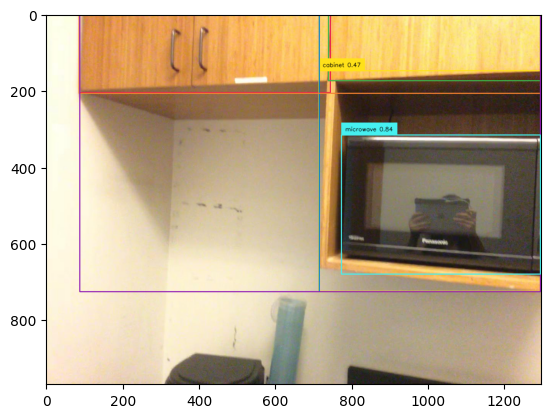

In [66]:
# plot prediction image in BGR
plt.imshow(cv2.cvtColor(np.array(prediction_image), cv2.COLOR_RGB2BGR))
plt.show()